# Практическая работа №1
## Тема: Предварительная обработка данных
## Выполнил: Шинкаренко Даниил Дмитриевич
## Группа: КИ21-16/1б
## Вариант: 24

## Цель работы
Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.

## Задачи
Выполнение практической работы предполагает решение следующий задач:

1. Визуальный анализ исходных данных
2. Поиск аномальных значений
3. Поиск и восстановление отсутствующих значений
4. Преобразование данных

## Ход работы
Импортируем необходимые библиотеки

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.impute

from functions import draw_charts, draw_histogram

data = pd.read_excel('dataframe.xlsx')
PRODUCT_TYPE = "cat13_productType"
TEMPERATURE = "cat14_temprature"
NUM1 = "num1_25"
NUM2 = "num2_25"
NUM3 = "num3_25"
headers = [PRODUCT_TYPE, TEMPERATURE, NUM1, NUM2, NUM3]
dataframe = pd.DataFrame(data[headers])
dataframe

,cat13_productType,cat14_temprature,num1_25,num2_25,num3_25
0,Wood,Very Hot,916.153076,294.981999,703.129209
1,Plastic,cold,531.175435,85.120795,614.411678
2,-,Very Hot,1214.908273,375.522597,530.122551
3,Plastic,Very Hot,-460.238016,652.067484,620.665623
4,metal,cold,-9999.000000,283.214616,558.01966
...,...,...,...,...,...
995,Wood,Very Hot,1551.439719,122.751805,701.794422
996,Wood,cold,-907.872075,247.809685,578.433583
997,Metal,Very Hot,36.495280,281.114939,615.993257
998,Wood,-,-14.590580,33.625780,-


## 1. Визуальный анализ данных
Для каждого признака в исходном наборе данных были созданы графики, которые помогают визуально представить данные. Все функции, используемые для построения этих графиков, были вынесены в отдельный файл functions.py.

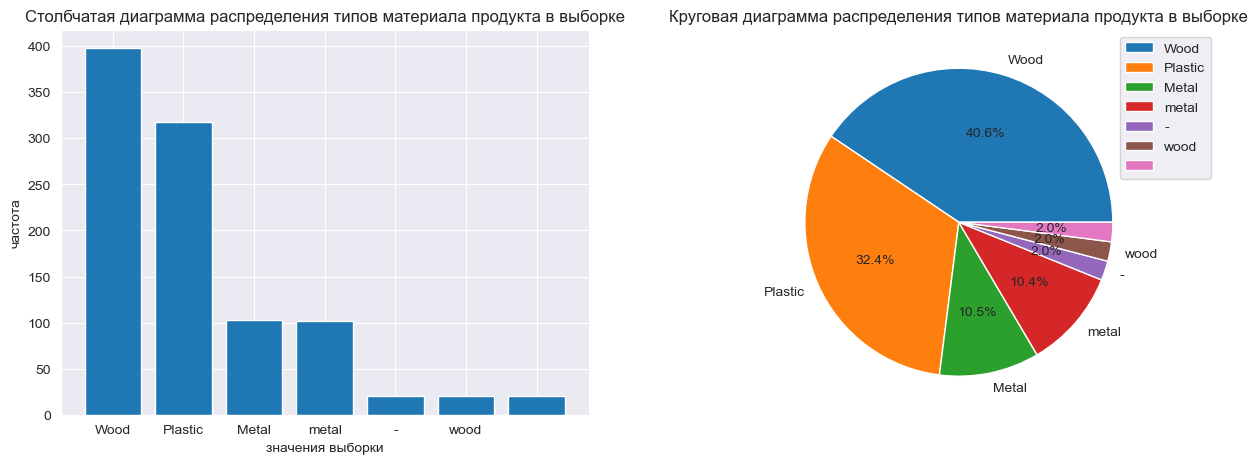

In [47]:
draw_charts(dataframe, PRODUCT_TYPE, "типов материала продукта")

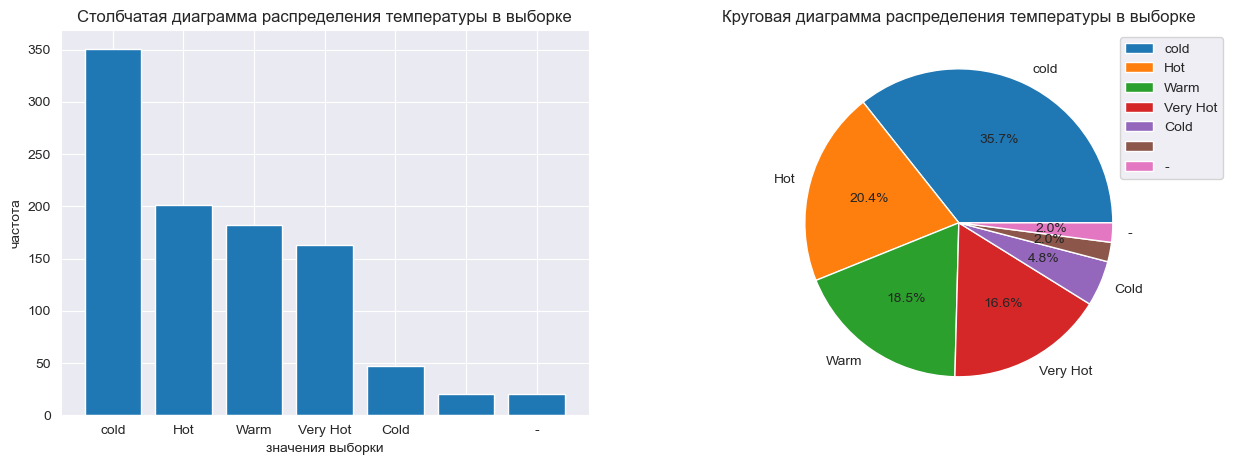

In [48]:
draw_charts(dataframe, TEMPERATURE, "температуры")

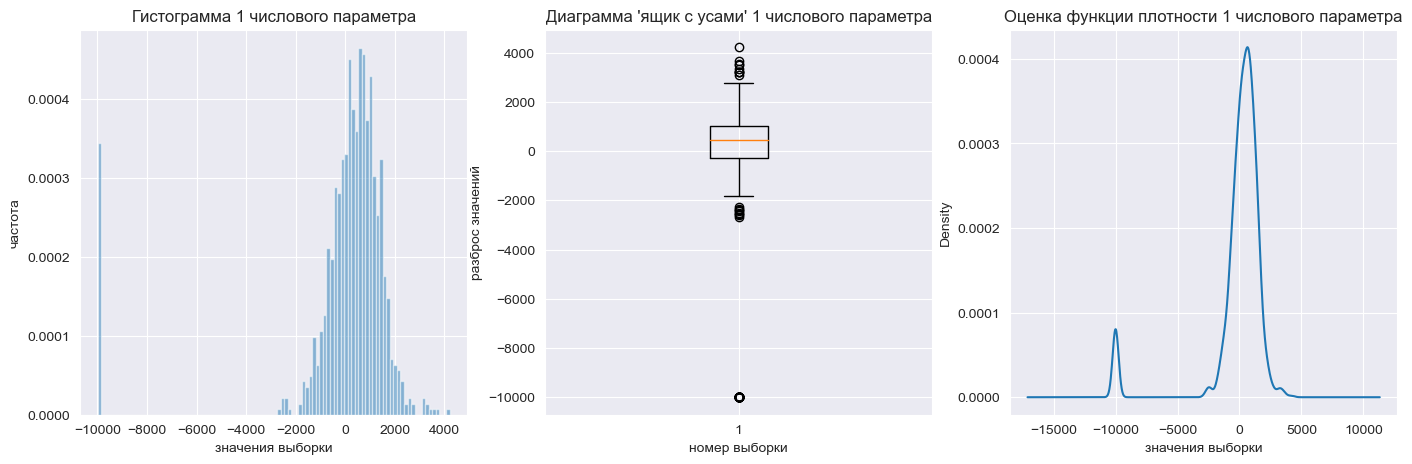

In [49]:
draw_histogram(dataframe, NUM1, 1)

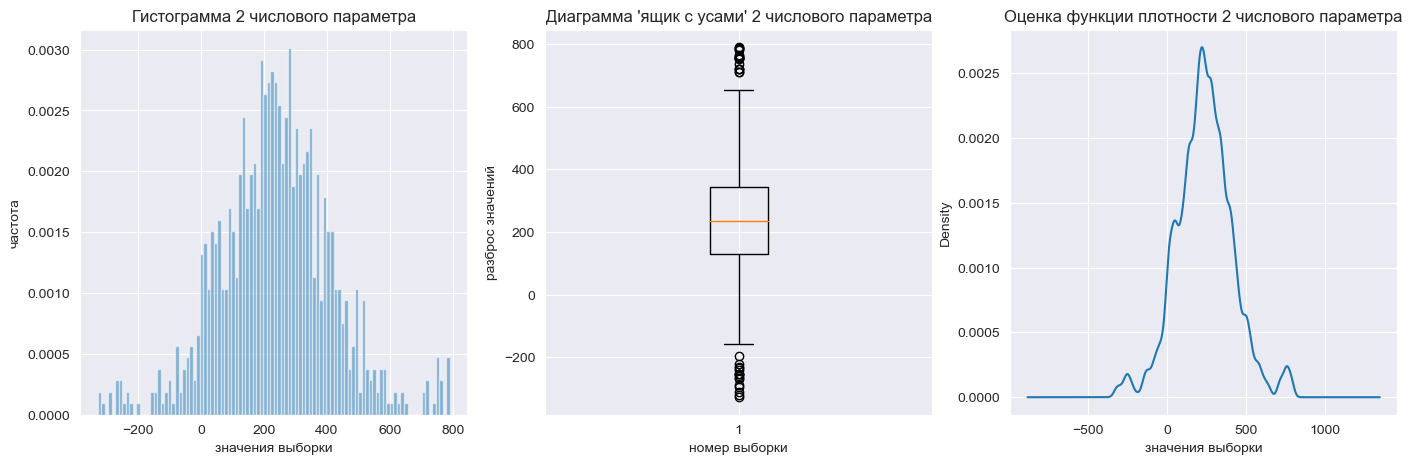

In [50]:
draw_histogram(dataframe, NUM2, 2)

График не может быть построен, так как столбец num3_25 содержит не только числовые значения.


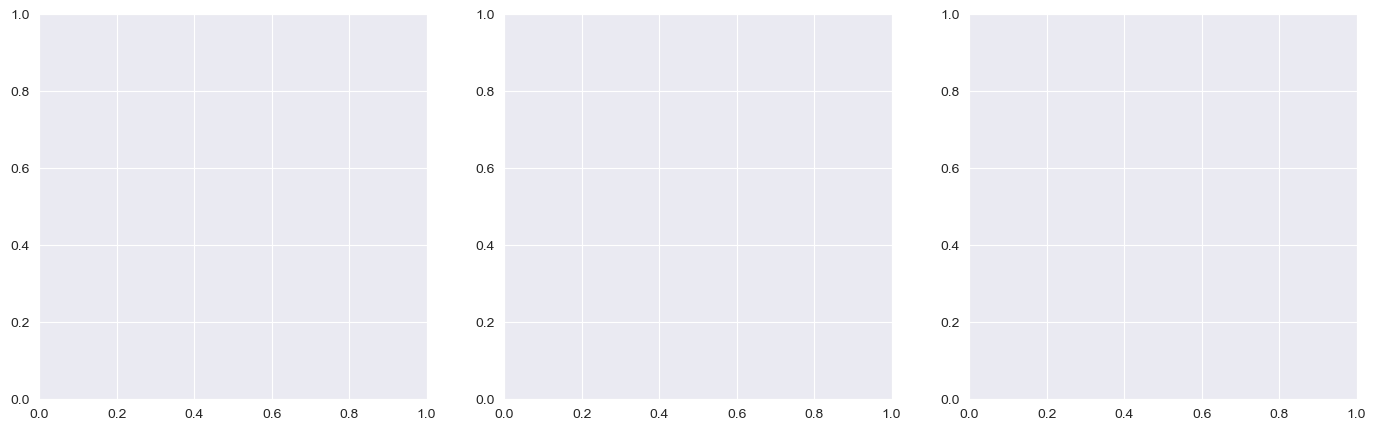

In [51]:
try:
    draw_histogram(dataframe, NUM3, 3)
except TypeError:
    print("График не может быть построен, так как столбец {} содержит не только числовые значения.".format(NUM3))

## 2. Проверка правдоподобности исходных данных
После анализа графиков можно заключить, что в таблице присутствуют некорректные значения, такие как пропущенные значения. Используя метод info, можно заметить, что некоторые столбцы имеют неверный тип данных.

In [52]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cat13_productType  981 non-null    object 
 1   cat14_temprature   984 non-null    object 
 2   num1_25            1000 non-null   float64
 3   num2_25            951 non-null    float64
 4   num3_25            973 non-null    object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


### Изменение качественных признаков
Для понимания процесса очистки данных выводим уникальные значения, содержащиеся в каждом столбце.

In [53]:
dataframe.cat13_productType.unique()

array(['Wood', 'Plastic', '-', 'metal', 'Metal', nan, 'wood', ' '],
      dtype=object)

In [54]:
dataframe.cat14_temprature.unique()

array(['Very Hot', 'cold', 'Hot', 'Cold', 'Warm', nan, ' ', '-'],
      dtype=object)

Выполним преобразование найденных значений в требуемый формат: все пустые значения заменим на None, а признаки, отличающиеся по формату написания, приведем к единому стилю.

In [55]:
mapping_prod = {" ": None, "-": None, "": None, np.nan: None, "wood": "Wood", "metal": "Metal"}
mapping_temp = {" ": None, "-": None, "": None, np.nan: None, "cold": "Cold"}

dataframe[PRODUCT_TYPE].replace(mapping_prod, inplace=True)
dataframe[TEMPERATURE].replace(mapping_temp, inplace=True)

Колонки 1 и 2 были преобразованы к категориальному(category) типу.

In [56]:
dataframe[PRODUCT_TYPE] = dataframe[PRODUCT_TYPE].astype("category")
dataframe[TEMPERATURE] = dataframe[TEMPERATURE].astype("category")

### Изменение количественных признаков

In [57]:
dataframe.num3_25.apply(lambda x: x if not isinstance(x, float) else None).unique()

array([None, ' ', '-'], dtype=object)

In [58]:
dataframe[NUM3].replace(to_replace=[" ", "-", "", None], value=pd.NA, inplace=True)

Построим ряд графиков исходя из обновленных значений последнего столбца.

TypeError: no numeric data to plot

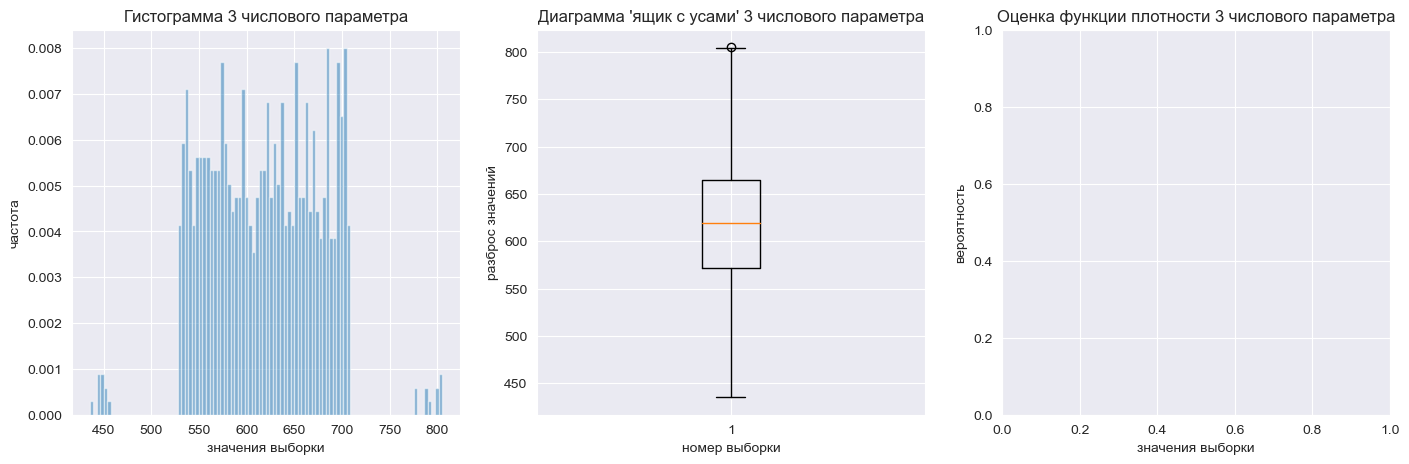

In [59]:
draw_histogram(dataframe, NUM3, 3)

In [60]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   cat13_productType  941 non-null    category
 1   cat14_temprature   944 non-null    category
 2   num1_25            1000 non-null   float64 
 3   num2_25            951 non-null    float64 
 4   num3_25            913 non-null    object  
dtypes: category(2), float64(2), object(1)
memory usage: 25.8+ KB


## 4. Поиск и восстановление пропущенных значений
Пропущенные значения второго признака были заполнены наиболее часто встречающимся значением.

In [62]:
print(dataframe[TEMPERATURE].value_counts())

Cold        398
Hot         201
Warm        182
Very Hot    163
Name: cat14_temprature, dtype: int64


In [63]:
dataframe[TEMPERATURE] = dataframe[TEMPERATURE].fillna("Cold")

Значения, которые отсутствовали в четвёртом признаке, были заполнены медианным значением.

In [64]:
dataframe[NUM2].fillna(dataframe[NUM2].median(), inplace=True)

Значения, отсутствующие в пятом признаке, были заполнены с использованием метода "k-ближайших соседей".

In [66]:
# Сохраняем выходные данные fit_transform() непосредственно в целевом столбце NUM3.
knn_imputer = sklearn.impute.KNNImputer()
dataframe[NUM3] = knn_imputer.fit_transform(dataframe[[NUM1, NUM2, NUM3]])[:, 2]
num_non_null = dataframe[NUM3].count()
print(f"Количество не нулевых элементов в NUM3: {num_non_null}")

TypeError: float() argument must be a string or a real number, not 'NAType'